In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.nn.init as init
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import glob
import cv2
from PIL import Image

In [6]:
# データ読み込み
folder_path = 'パスの入力'

# img_size = ( 256,256 )

path = glob.glob( os.path.join( folder_path, "*.jpg" ) )
data = np.array([ cv2.imread(path) for path in path ]).astype( 'float32' )
# data = np.array([ cv2.resize( data, img_size ) for data in data ])        # 画像サイズを変更する場合
data = np.array([ img[ :, :, ::-1] for img in data ])
data = [ Image.fromarray( img.astype(np.uint8)).convert('RGB') for img in data ]
# data = [ img.transpose((1, 2, 0)) for img in data ]
data = np.array(data).transpose((0, 1, 2, 3))
print( "img num:{}, img size:{}".format( len(data), np.array(data).size ) )

img num:1867, img size:56010000


In [7]:
label = [0 if ("Healthy" in p) else 1 if ("Damaged" in p) else 2 for p in path]

In [8]:
# GPUの確認

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Dataloaderの作成

In [9]:
transform = transforms.ToTensor()

In [10]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, label, data, transform):
        self.transform = transform
        self.labelset = label
        self.dataset = data

        self.datanum = len(label)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_label = self.labelset[idx]
        out_data = self.dataset[idx]

        out_label = torch.tensor(out_label,dtype=torch.long)
        out_data = self.transform(out_data)
        return out_data, out_label

In [11]:
batch_size = 100

dataset = Mydatasets(label, data, transform)
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size+1])

data_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_ dataset, batch_size, shuffle=False)

In [12]:
# ResNet18のプリトレインモデルを読み込み
resnet18 = models.resnet18(pretrained = True)
backbone = nn.Sequential(*list(resnet18.children())[:-1])   # 最終層を削除

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = backbone

        # 全結合層
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.backbone(x).reshape(-1, 512)

        # 全結合層
        fc = self.fc(x)

        return fc

# モデルのインスタンス化
model = Model()

model = model.to(device)


In [14]:
from torchsummary import summary
summary(model.to(device), (3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

損失関数と最適化関数

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [16]:
# 学習ループ

num_epoch = 10

train_loss_list = []
train_acc_list = []

for epoch in range(num_epoch):
    train_loss = 0
    train_acc  = 0

    # 学習時間
    start = time.time()

    model.train()
    for images, labels in data_loader:
        # 勾配の初期化(ループの頭でやる必要あり)
        optimizer.zero_grad()

        # 訓練データの準備
        images = images.to(device)
        labels = labels.to(device)

        # 順伝搬計算
        outputs = model(images)

        # 誤差計算
        loss = criterion( outputs, labels )
        train_loss += loss.item()

        # 学習
        loss.backward()
        optimizer.step()


        #予測値算出
        predicted = outputs.max(1)[1]

        #正解件数算出
        train_acc += (predicted == labels).sum()

    # # 訓練データに対する損失と精度の計算
    avg_train_loss = train_loss / len(data_loader.dataset)
    avg_train_acc = train_acc / len(data_loader.dataset)


    # 損失と精度の表示
    elapsed = time.time() - start
    print (f'Epoch [{(epoch+1):2}/{num_epoch}] - {elapsed:0.2f}s - loss: {avg_train_loss:.5f} - acc: {avg_train_acc:.5f}')
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)

Epoch [ 1/10] - 1.64s - loss: 0.00502 - acc: 0.79004
Epoch [ 2/10] - 0.54s - loss: 0.00228 - acc: 0.90305
Epoch [ 3/10] - 0.52s - loss: 0.00118 - acc: 0.95340
Epoch [ 4/10] - 0.54s - loss: 0.00050 - acc: 0.98179
Epoch [ 5/10] - 0.53s - loss: 0.00072 - acc: 0.97161
Epoch [ 6/10] - 0.53s - loss: 0.00082 - acc: 0.97001
Epoch [ 7/10] - 0.53s - loss: 0.00037 - acc: 0.98875
Epoch [ 8/10] - 0.53s - loss: 0.00068 - acc: 0.97697
Epoch [ 9/10] - 0.53s - loss: 0.00046 - acc: 0.98286
Epoch [10/10] - 0.53s - loss: 0.00049 - acc: 0.98286


In [17]:
pred_list = []
label_list = []
model.eval()
for i,(img, labels) in enumerate(test_loader):
    img = img.to(device)
    pred = model(img)

    label_list.extend(labels.tolist())

    pred_list.extend(pred.tolist())
pred = np.argmax(pred_list , axis=1 )
diff_index = np.arange( len(label_list) )[ label_list != pred]


label:0 = 健康

label:1 = 損傷

label:2 = 死亡

9/1867


C:\Users\Owner\AppData\Local\Temp\ipykernel_17780\2759323480.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


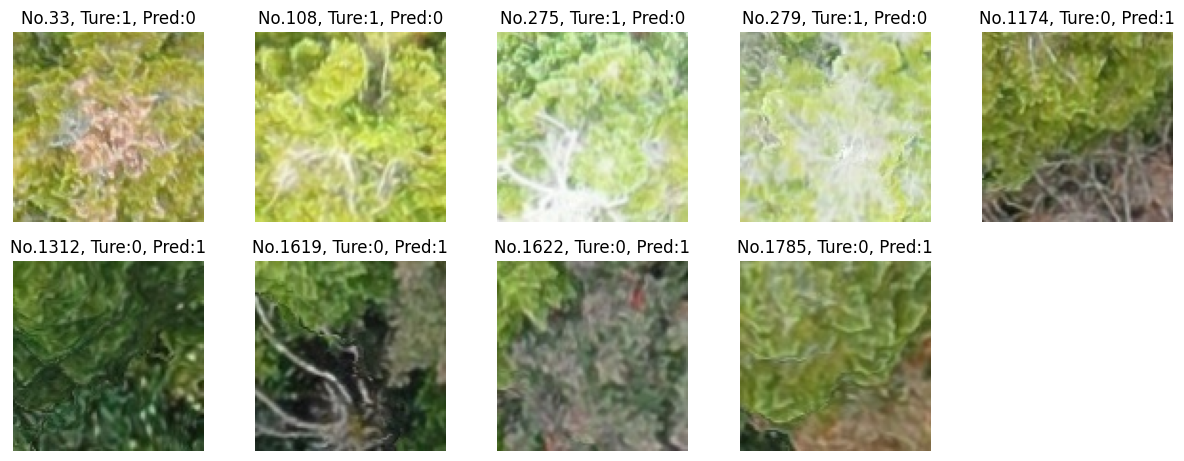

In [18]:
print(f"{len(diff_index)}/{len(label)}")
plt.figure( figsize=(12,7) )

for i,diff in enumerate( diff_index[:15] ):
    plt.subplot( 3, 5, i+1 )
    plt.tight_layout()
    plt.title(  "No.{}, Ture:{}, Pred:{}".format( diff, label[diff], pred[diff] ) )
    plt.imshow( data[diff] )
    plt.axis("off")

plt.savefig("ResNet18-5.png")
plt.show()

In [19]:
import requests

def line_notify(text):

    line_notify_token = 'gmcmGI7yJudAbCFyCj6ZbszFkDd42T6m6LAWfL1OVm4'
    line_notify_api = 'https://notify-api.line.me/api/notify'

    message = ('\n{0}'.format(text))

    payload = {'message': message}
    headers = {'Authorization': 'Bearer ' + line_notify_token}
    requests.post(line_notify_api, data=payload, headers=headers)

line_notify('python')